# Step1: Scrape Real-world Dataset

The data used in this report comes from the CoinGecko website through its public API. CoinGecko is the world’s largest independent cryptocurrency data aggregator, integrating data from more than 1,000 crypto exchanges and listing over 18,000 coins across 600+ categories.

For this report, I collected the following variables of interest within a one-year time range: date, price, market_cap, volume_24h, coin_id, coin_name, and category. These data were obtained by programmatically accessing CoinGecko’s API endpoints and retrieving the relevant market information for each selected cryptocurrency.

In [2]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal,levene

In [ ]:
# CoinGecko API Configuration
API_KEY = "CG-o6J3GwRFpBWgZVkBb7ceMeLc" # create a API key from the CoinGecko website
BASE_URL = "https://api.coingecko.com/api/v3"

# Define categories to fetch
CATEGORIES = {
    'Layer 1': 'layer-1',
    'DeFi': 'decentralized-finance-defi',
    'GameFi': 'gaming'
}

# Define time range: past 1 year
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=365)  # Past 1 year, this is the limit of free regualr users

print(f"Time range: {START_DATE.strftime('%Y-%m-%d')} to {END_DATE.strftime('%Y-%m-%d')} (past 1 year)")

def get_category_data(category_id, api_key):
    """
    Fetch current data for top 10 coins by market cap in the specified category
    """
    url = f"{BASE_URL}/coins/markets"
    params = {
        'vs_currency': 'usd',
        'category': category_id,
        'order': 'market_cap_desc',
        'per_page': 10,  # Fetch top 10 coins by market cap
        'page': 1,
        'sparkline': False
    }
    
    headers = {
        'x-cg-demo-api-key': api_key
    }
    
    try:
        response = requests.get(url, params=params, headers=headers)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error: Status code {response.status_code}")
            print(f"Response content: {response.text[:500]}")
            return None
    except Exception as e:
        print(f"Request failed: {e}")
        return None

def get_historical_data(coin_id, start_date, end_date, api_key):
    """
    Fetch historical data for the specified coin (past 1 year)
    """
    url = f"{BASE_URL}/coins/{coin_id}/market_chart/range"
    params = {
        'vs_currency': 'usd',
        'from': int(start_date.timestamp()),
        'to': int(end_date.timestamp())
    }
    
    headers = {
        'x-cg-demo-api-key': api_key
    }
    
    try:
        response = requests.get(url, params=params, headers=headers)
        if response.status_code == 200:
            return response.json()

    except Exception as e:
        print(f"  Failed to fetch historical data for {coin_id}: {e}")
        return None

# Store all raw data
all_current_data = {}
all_historical_data = {}

print("="*80)
print("Starting to download raw data (past 1 year)")
print(f"Time range: {START_DATE.strftime('%Y-%m-%d')} to {END_DATE.strftime('%Y-%m-%d')}")
print("="*80)

# Fetch data for each category
for category_name, category_id in CATEGORIES.items():
    print(f"\n【{category_name} Category】")
    
    # 1. Fetch current data (top 10 coins by market cap)
    print(f"Fetching current data for {category_name} category (top 10 coins by market cap)...")
    current_data = get_category_data(category_id, API_KEY)
    
    if not current_data or len(current_data) == 0:
        print(f"No data retrieved for {category_name} category")
        continue
    
    # Save current data as DataFrame
    current_df = pd.DataFrame(current_data)
    all_current_data[category_name] = current_df
    print(f"✓ Successfully retrieved current data for {len(current_df)} coins")
    
    # 2. Fetch historical data for each coin
    coin_ids = current_df['id'].tolist()
    coin_names = current_df['name'].tolist()
    
    print(f"Fetching historical data for top 10 coins in {category_name} category (past 1 year)...")
    category_historical_data = []
    
    for i, (coin_id, coin_name) in enumerate(zip(coin_ids, coin_names), 1):
        print(f"  [{i}/10] Fetching historical data for {coin_name} ({coin_id})...")
        historical_data = get_historical_data(coin_id, START_DATE, END_DATE, API_KEY)
        
        if historical_data:
            prices = historical_data.get('prices', [])
            market_caps = historical_data.get('market_caps', [])
            total_volumes = historical_data.get('total_volumes', [])
            
            if prices:
                hist_df = pd.DataFrame({
                    'timestamp': [p[0] for p in prices],
                    'date': pd.to_datetime([p[0] for p in prices], unit='ms'),
                    'price': [p[1] for p in prices],
                    'market_cap': [mc[1] if mc and len(mc) > 1 and mc[1] else None for mc in market_caps] if market_caps else [None] * len(prices),
                    'volume_24h': [tv[1] if tv and len(tv) > 1 and tv[1] else None for tv in total_volumes] if total_volumes else [None] * len(prices),
                    'coin_id': coin_id,
                    'coin_name': coin_name,
                    'category': category_name
                })
                category_historical_data.append(hist_df)
                print(f"    ✓ Successfully retrieved {len(hist_df)} historical records")
            else:
                print(f"    ✗ {coin_name} has no historical price data")
        else:
            print(f"    ✗ Unable to retrieve historical data for {coin_name}")
        
        time.sleep(1.2)
    
    # Merge all historical data for this category
    if category_historical_data:
        all_historical_data[category_name] = pd.concat(category_historical_data, ignore_index=True)
        print(f"✓ {category_name} category historical data total: {len(all_historical_data[category_name])} records")
    else:
        all_historical_data[category_name] = pd.DataFrame()
        print(f"✗ {category_name} category has no historical data")
    
    time.sleep(2)

print("\n" + "="*80)
print("Data download completed")
print("="*80)

Time range: 2024-12-02 to 2025-12-02 (past 1 year)
Starting to download raw data (past 1 year)
Time range: 2024-12-02 to 2025-12-02

【Layer 1 Category】
Fetching current data for Layer 1 category (top 10 coins by market cap)...
✓ Successfully retrieved current data for 10 coins
Fetching historical data for top 10 coins in Layer 1 category (past 1 year)...
  [1/10] Fetching historical data for Bitcoin (bitcoin)...
    ✓ Successfully retrieved 365 historical records
  [2/10] Fetching historical data for Ethereum (ethereum)...
    ✓ Successfully retrieved 365 historical records
  [3/10] Fetching historical data for BNB (binancecoin)...
    ✓ Successfully retrieved 365 historical records
  [4/10] Fetching historical data for Solana (solana)...
    ✓ Successfully retrieved 365 historical records
  [5/10] Fetching historical data for TRON (tron)...
    ✓ Successfully retrieved 365 historical records
  [6/10] Fetching historical data for Cardano (cardano)...
    ✓ Successfully retrieved 365 hi

In [218]:
# Save raw data to CSV files
print("\n" + "="*80)
print("Saving raw data to CSV files")
print("="*80)

# Merge all historical data into one file
if all_historical_data:
    all_historical_combined = pd.concat([df for df in all_historical_data.values() if not df.empty], ignore_index=True)
    if not all_historical_combined.empty:
        all_historical_combined.to_csv('DATA.csv', index=False, encoding='utf-8-sig')
        print(f"\n✓ All category historical data merged and saved: DATA.csv")
        print(f"  Total records: {len(all_historical_combined):,}")
        print(f"  Time range: {all_historical_combined['date'].min().strftime('%Y-%m-%d')} to {all_historical_combined['date'].max().strftime('%Y-%m-%d')}")

print("\n" + "="*80)
print("All raw data saved successfully!")
print("="*80)



Saving raw data to CSV files

✓ All category historical data merged and saved: DATA.csv
  Total records: 10,341
  Time range: 2024-12-03 to 2025-12-02

All raw data saved successfully!


## Variable Explainatin



| Variable | Description |
|----------|-------------|
| Layer 1 | Primary blockchain networks that serve as autonomous, foundational infrastructure for transaction execution and validation, operating independently without reliance on other blockchain systems. |
| GameFi | A sector combining blockchain technology, gaming mechanics, and decentralized finance (DeFi), enabling players to earn cryptocurrency and non-fungible token (NFT) rewards while maintaining true ownership and transferability of in-game assets. |
| DeFi | A financial ecosystem operating on blockchain technology without central intermediaries, utilizing smart contracts to facilitate peer-to-peer financial services including lending, borrowing, trading, and yield farming. |
| category | filter based on coins' category. |
| price | coin price in currency. |
| market_cap | coin market cap in currency. |
| volumn_24h | historical market data |

# Step 2: Perform data preparation and cleaning

read saved csv file from local

In [3]:
all_historical_combined = pd.read_csv('DATA.csv')

Upon examining the top ten cryptocurrencies in each sector, it was found that *Aster* and *Rain* in the DeFi sector exhibit **significant data missing**, while *Legacy Token* in the GameFi sector shows **minor data gaps**.


In [4]:
all_historical_combined.groupby(['category', 'coin_name'])[['price', 'market_cap', 'volume_24h']].count()

price  market_cap  volume_24h
category coin_name                                       
DeFi     Aave                 365         365         365
         Aster                 75          75          75
         Chainlink            365         365         365
         Dai                  365         365         365
         Ethena               365         365         365
         Hyperliquid          365         365         365
         Lido Staked Ether    365         365         365
         Rain                  83          20          83
         Uniswap              365         365         365
         Wrapped stETH        365         365         365
GameFi   ApeCoin              365         365         365
         Axie Infinity        365         365         365
         Decentraland         365         365         365
         FLOKI                365         365         365
         GALA                 365         365         365
         Immutable            365         365         365
         Legacy Token         328         177         328
         The Sandbox          365         365         365
         Undeads Games        365         365         365
         WEMIX                365         365         365
Layer 1  BNB                  365         365         365
         Bitcoin              365         365         365
         Bitcoin Cash         365         365         365
         Cardano              365         365         365
         Ethereum             365         365         365
         Hyperliquid          365         365         365
         Litecoin             365         365         365
         Monero               365         365         365
         Solana               365         365         365
         TRON                 365         365         365

To ensure the reliability of the conclusions, this report applies different handling strategies based on the severity of the missing data. Data with significant missing values were excluded, whereas missing values of a minor nature were imputed using the median.

In [5]:
all_historical_combined = all_historical_combined.drop(all_historical_combined[(all_historical_combined['coin_name'] == 'Aster') | (all_historical_combined['coin_name'] == 'Rain')].index)
all_historical_combined[all_historical_combined['coin_name'] == 'Legacy Token'][['price','market_cap','volume_24h']].median()
# Get all dates for GameFi category
gamefi_dates = all_historical_combined[all_historical_combined['category'] == 'GameFi']['date'].unique()

# Sort dates to prevent disorder
gamefi_dates = pd.to_datetime(gamefi_dates)
gamefi_dates = pd.Series(gamefi_dates).sort_values().reset_index(drop=True)

legacy = all_historical_combined[all_historical_combined['coin_name'] == 'Legacy Token'].copy()
legacy['date'] = pd.to_datetime(legacy['date'])
legacy = legacy.sort_values('date').set_index('date')

legacy_reindexed = legacy.reindex(gamefi_dates)
medians = legacy[['price','market_cap','volume_24h']].median()
legacy_filled = legacy_reindexed.fillna({
    'price': medians['price'],
    'market_cap': medians['market_cap'],
    'volume_24h': medians['volume_24h'],
    'category': 'GameFi',
    'coin_name': 'Legacy Token'
})

all_historical_combined_filled = (
    all_historical_combined[all_historical_combined['coin_name'] != 'Legacy Token']
)

all_historical_combined_filled = pd.concat(
    [all_historical_combined_filled, legacy_filled],
    ignore_index=True
)

### Handle Outliers and Inconsistencies

In financial data, especially cryptocurrency data, significant variations between different coins within the same category are expected due to differences in market capitalization, adoption, and maturity. However, we need to identify and handle:

1. **Data inconsistencies**: Logical errors such as negative prices or mismatched relationships between price, market cap, and volume
2. **True outliers**: Extreme values that may represent data errors or exceptional market events that could skew the analysis

For this analysis, we apply outlier detection methods **within each category** to account for the natural scale differences between categories (e.g., Layer 1 coins typically have much higher market caps than GameFi coins).



In [6]:
# Step 1: Detect and handle data inconsistencies
print("="*80)
print("Step 1: Detecting Data Inconsistencies")
print("="*80)

# Check for logical inconsistencies
inconsistencies = []

# 1. Negative or zero prices
negative_prices = all_historical_combined_filled[all_historical_combined_filled['price'] <= 0]
if len(negative_prices) > 0:
    print(f"Found {len(negative_prices)} records with non-positive prices")
    inconsistencies.append(negative_prices)
else:
    print("✓ No negative or zero prices found")

# 2. Negative volumes 
negative_volumes = all_historical_combined_filled[all_historical_combined_filled['volume_24h'] < 0]
if len(negative_volumes) > 0:
    print(f"Found {len(negative_volumes)} records with negative volumes")
    inconsistencies.append(negative_volumes)
else:
    print("✓ No negative volumes found")

# Remove inconsistent records
if inconsistencies:
    inconsistent_indices = pd.concat(inconsistencies).index.unique()
    print(f"\nRemoving {len(inconsistent_indices)} inconsistent records")
    all_historical_combined_filled = all_historical_combined_filled.drop(inconsistent_indices)
    print(f"Remaining records: {len(all_historical_combined_filled):,}")
else:
    print("\n✓ No data inconsistencies detected")



Step 1: Detecting Data Inconsistencies
✓ No negative or zero prices found
✓ No negative volumes found

✓ No data inconsistencies detected


In [8]:
# Step 2: Detect and handle outliers using IQR method (within each category)
print("\n" + "="*80)
print("Step 2: Detecting Outliers Using IQR Method (Within Each Category)")
print("="*80)

def detect_outliers_iqr(df, column, category_col='category', multiplier=3.0):
    """
    Detect outliers using IQR method within each category.
    
    Parameters:
    - df: DataFrame
    - column: column name to check for outliers
    - category_col: column name for grouping (default: 'category')
    - multiplier: IQR multiplier (default: 3.0 for more conservative detection)
    
    Returns:
    - DataFrame with outlier flags
    """
    outlier_flags = pd.Series(False, index=df.index)
    
    for category in df[category_col].unique():
        category_data = df[df[category_col] == category][column]
        
        Q1 = category_data.quantile(0.25)
        Q3 = category_data.quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        category_indices = df[df[category_col] == category].index
        outliers = (category_data < lower_bound) | (category_data > upper_bound)
        outlier_flags.loc[category_indices[outliers]] = True
        
        if outliers.sum() > 0:
            print(f"\n{category} - {column}:")
            print(f"  Q1: {Q1:.2e}, Q3: {Q3:.2e}, IQR: {IQR:.2e}")
            print(f"  Bounds: [{lower_bound:.2e}, {upper_bound:.2e}]")
            print(f"  Outliers detected: {outliers.sum()} ({outliers.sum()/len(category_data)*100:.2f}%)")
    
    return outlier_flags

# Detect outliers for key numeric columns
numeric_cols = ['price', 'market_cap', 'volume_24h']
outlier_summary = {}

for col in numeric_cols:
    print(f"\n{'='*60}")
    print(f"Checking outliers in: {col}")
    print('='*60)
    outlier_flags = detect_outliers_iqr(all_historical_combined_filled, col, multiplier=3.0)
    outlier_summary[col] = outlier_flags
    print(f"\nTotal outliers in {col}: {outlier_flags.sum()} ({outlier_flags.sum()/len(all_historical_combined_filled)*100:.2f}%)")

# Combine outlier flags (a record is an outlier if it's an outlier in any column)
combined_outlier_flags = pd.concat(outlier_summary, axis=1).any(axis=1)
total_outliers = combined_outlier_flags.sum()

print("\n" + "="*80)
print(f"Summary: {total_outliers} records ({total_outliers/len(all_historical_combined_filled)*100:.2f}%) are outliers in at least one variable")
print("="*80)



Step 2: Detecting Outliers Using IQR Method (Within Each Category)

Checking outliers in: price

Layer 1 - price:
  Q1: 3.35e+01, Q3: 6.90e+02, IQR: 6.56e+02
  Bounds: [-1.93e+03, 2.66e+03]
  Outliers detected: 597 (16.36%)

DeFi - price:
  Q1: 3.89e+00, Q3: 6.55e+02, IQR: 6.51e+02
  Bounds: [-1.95e+03, 2.61e+03]
  Outliers detected: 542 (18.56%)

GameFi - price:
  Q1: 2.36e-01, Q3: 1.18e+00, IQR: 9.47e-01
  Bounds: [-2.61e+00, 4.03e+00]
  Outliers detected: 82 (2.25%)

Total outliers in price: 1221 (11.95%)

Checking outliers in: market_cap

Layer 1 - market_cap:
  Q1: 8.60e+09, Q3: 1.10e+11, IQR: 1.02e+11
  Bounds: [-2.96e+11, 4.15e+11]
  Outliers detected: 502 (13.75%)

DeFi - market_cap:
  Q1: 3.71e+09, Q3: 1.33e+10, IQR: 9.57e+09
  Bounds: [-2.50e+10, 4.20e+10]
  Outliers detected: 2 (0.07%)

GameFi - market_cap:
  Q1: 2.58e+08, Q3: 8.06e+08, IQR: 5.48e+08
  Bounds: [-1.39e+09, 2.45e+09]
  Outliers detected: 31 (0.85%)

Total outliers in market_cap: 535 (5.23%)

Checking outliers


Step 3: Visualizing Outliers


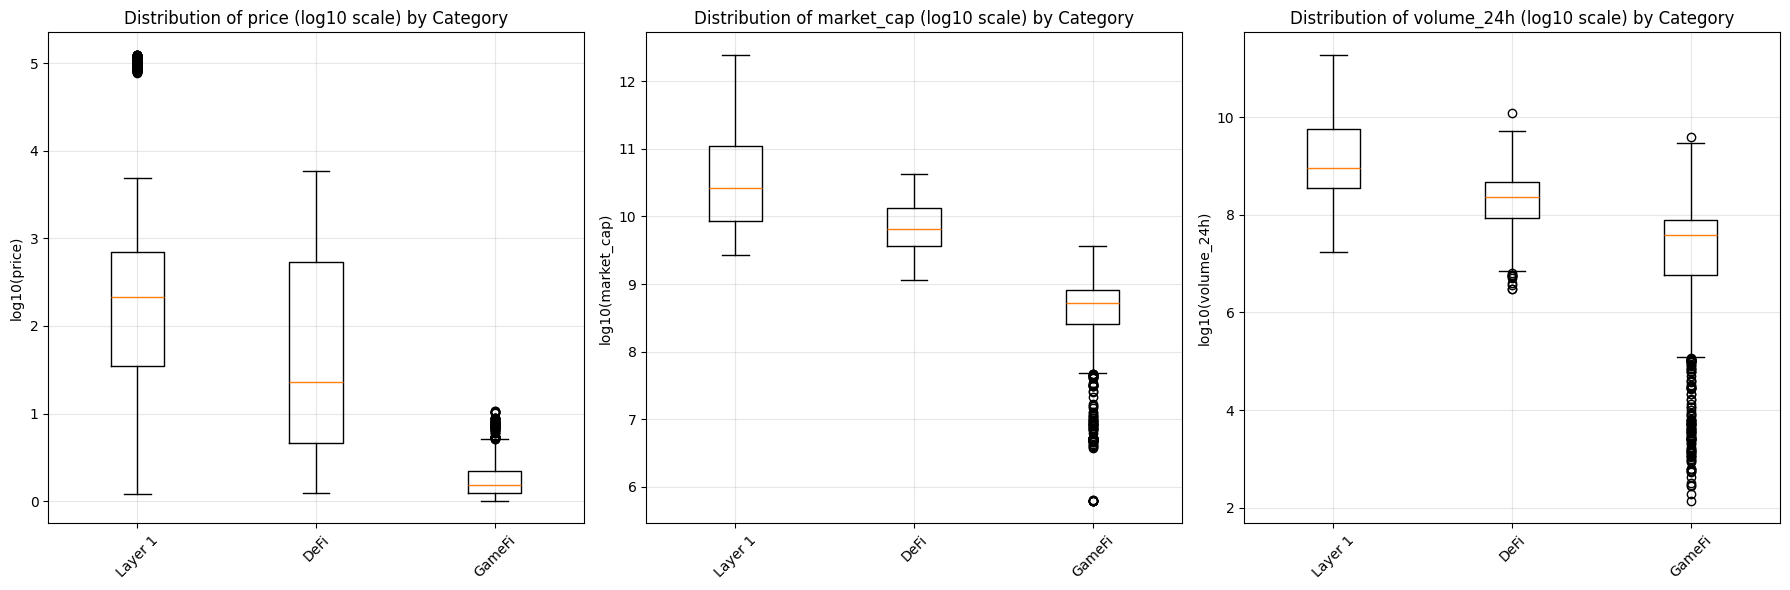


Sample outlier records:
         date category coin_name          price    market_cap    volume_24h
0  2024-12-03  Layer 1   Bitcoin   95833.136230  1.896577e+12  1.010199e+11
1  2024-12-04  Layer 1   Bitcoin   96031.630978  1.900922e+12  8.793575e+10
2  2024-12-05  Layer 1   Bitcoin   98881.469456  1.957276e+12  9.823078e+10
3  2024-12-06  Layer 1   Bitcoin   97201.500364  1.920743e+12  1.904603e+11
4  2024-12-07  Layer 1   Bitcoin   99973.851507  1.978390e+12  1.158126e+11
5  2024-12-08  Layer 1   Bitcoin   99781.829992  1.974739e+12  6.106114e+10
6  2024-12-09  Layer 1   Bitcoin  101235.371703  2.003239e+12  6.267776e+10
7  2024-12-10  Layer 1   Bitcoin   97353.947008  1.926048e+12  1.468468e+11
8  2024-12-11  Layer 1   Bitcoin   96649.714468  1.913116e+12  1.258360e+11
9  2024-12-12  Layer 1   Bitcoin  101123.618110  2.001746e+12  1.184850e+11


In [ ]:
# Step 3: Visualize outliers and decide on handling strategy
print("\n" + "="*80)
print("Step 3: Visualizing Outliers")
print("="*80)

# Create box plots for each category to visualize outliers
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
numeric_cols = ['price', 'market_cap', 'volume_24h']

for idx, col in enumerate(numeric_cols):
    ax = axes[idx]
    
    # Prepare data for boxplot (grouped by category)
    data_for_boxplot = []
    labels = []
    
    for category in all_historical_combined_filled['category'].unique():
        category_data = all_historical_combined_filled[
            all_historical_combined_filled['category'] == category
        ][col].dropna()
        # Use log transform for visualization due to large scale differences
        if col in ['price', 'market_cap', 'volume_24h']:
            category_data = np.log10(category_data + 1)  # +1 to handle zeros
        data_for_boxplot.append(category_data)
        labels.append(category)
    
    ax.boxplot(data_for_boxplot, labels=labels)
    ax.set_title(f'Distribution of {col} (log10 scale) by Category')
    ax.set_ylabel(f'log10({col})')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display some examples of outlier records
print("\nSample outlier records:")
outlier_records = all_historical_combined_filled[combined_outlier_flags].head(10)
print(outlier_records[['date', 'category', 'coin_name', 'price', 'market_cap', 'volume_24h']].to_string())



## Feature engineering

I computed the daily changing rate for price, market_cap and volume data, illustrating the volidability of coin

In [10]:
# Assume df has 'date', 'coin_name', 'price'
df = all_historical_combined_filled.copy()

# 1. Sort by coin_name and date
df = df.sort_values(by=['coin_name', 'date'])

# 2. Calculate log returns grouped by coin
df['price_log_return'] = df.groupby('coin_name')['price'].transform(lambda x: np.log(x) - np.log(x.shift(1)))
df['market_cap_log_return'] = df.groupby('coin_name')['market_cap'].transform(lambda x: np.log(x) - np.log(x.shift(1)))
df['volume_log_return'] = df.groupby('coin_name')['volume_24h'].transform(lambda x: np.log(x) - np.log(x.shift(1)))

# Fill first day returns with 0
df[['price_log_return', 'market_cap_log_return', 'volume_log_return']] = \
    df[['price_log_return', 'market_cap_log_return', 'volume_log_return']].fillna(0)



In [11]:
all_historical_combined_filled.groupby(['category','coin_name'])[['price','volume_24h']].mean()

price    volume_24h
category coin_name                                     
DeFi     Aave                  252.981987  5.113885e+08
         Chainlink              18.087853  9.614667e+08
         Dai                     0.999853  1.281805e+08
         Ethena                  0.523948  4.807791e+08
         Hyperliquid            31.793733  3.252725e+08
         Lido Staked Ether    3113.683063  6.953933e+07
         Uniswap                 8.708288  4.576988e+08
         Wrapped stETH        3751.714328  4.712476e+07
GameFi   ApeCoin                 0.676013  7.919262e+07
         Axie Infinity           3.237888  5.301157e+07
         Decentraland            0.325268  6.502330e+07
         FLOKI                   0.000100  1.857849e+08
         GALA                    0.019957  1.421945e+08
         Immutable               0.714144  5.390380e+07
         Legacy Token            1.750511  4.388408e+06
         The Sandbox             0.337123  1.373411e+08
         Undeads Games           1.035286  6.421672e+05
         WEMIX                   0.655388  5.364615e+06
Layer 1  BNB                   758.389709  1.639295e+09
         Bitcoin            102398.102077  4.799350e+10
         Bitcoin Cash          460.938863  3.379266e+08
         Cardano                 0.762872  1.308463e+09
         Ethereum             3116.881119  2.857555e+10
         Hyperliquid            31.793733  3.252725e+08
         Litecoin              102.282560  7.809501e+08
         Monero                276.019403  1.054964e+08
         Solana                176.548468  6.558060e+09
         TRON                    0.281267  1.108421e+09

# Step 3: Perform exploratory analysis

Market_cap proportion of each sector

In order to make comparisons between three sectors, this report draws a pie chart illustrating the average market_capital of each sector. As shown in the pie chart, Layer1 dominates the crypto market, accounting for 96%.

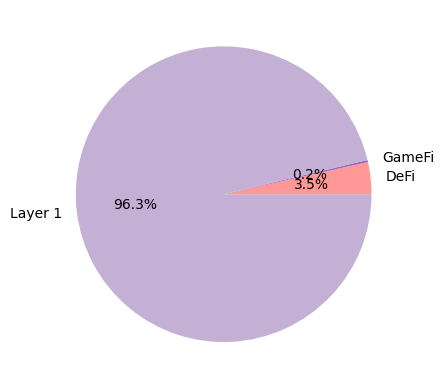

In [12]:
cate = (
    all_historical_combined_filled
    .groupby(['category'])['market_cap']
    .mean()
    .reset_index()
)
cate['percent'] = cate['market_cap']/sum(cate['market_cap'])*100
colors = plt.cm.tab20.colors[7:]  # 20 colors, cycle through
plt.pie(cate['percent'],labels=cate['category'],autopct='%1.1f%%',colors=colors)
plt.show()

Top 10 dominant coin in each sector

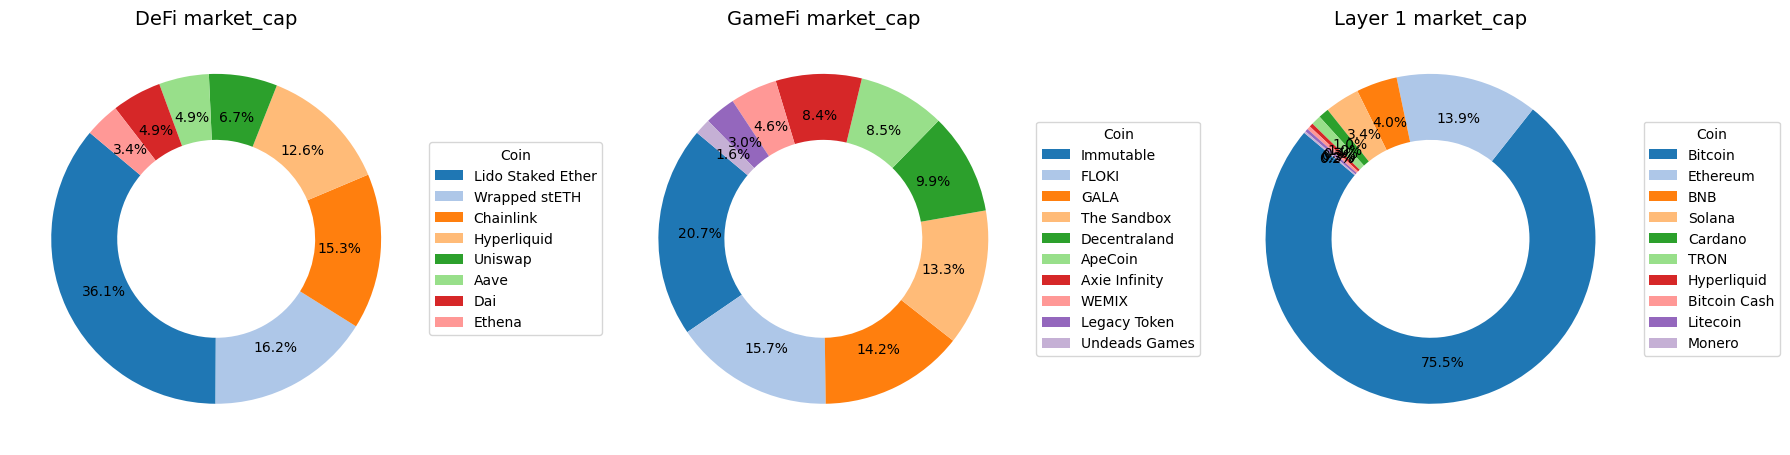

In [13]:
# Average market cap for each coin
grouped = (
    all_historical_combined_filled
    .groupby(['category', 'coin_name'])['market_cap']
    .mean()
    .reset_index()
)

# Total market cap for each category
total_cap = (
    grouped.groupby('category')['market_cap']
    .sum()
    .reset_index()
    .rename(columns={'market_cap': 'total_market_cap'})
)

# Merge
grouped = grouped.merge(total_cap, on='category', how='left')

# Percentage
grouped['percent'] = grouped['market_cap'] / grouped['total_market_cap'] * 100


categories = grouped['category'].unique()

colors = plt.cm.tab20.colors  # 20 colors, cycle through

# Create subplot with one row and three columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, cat in zip(axes, categories):
    df_cat = grouped[grouped['category'] == cat].sort_values('market_cap', ascending=False)
    wedges, texts, autotexts = ax.pie(
        df_cat['market_cap'],
        autopct='%1.1f%%',         # Display percentage on ring
        startangle=140,
        colors=colors,
        pctdistance=0.75,          # Percentage displayed further out on ring
        wedgeprops={'width':0.4}   # Width controls ring thickness
    )
    
    # Set empty circle in ring center
    centre_circle = plt.Circle((0,0),0.55,fc='white')
    ax.add_artist(centre_circle)
    
    ax.set_title(f'{cat} market_cap', fontsize=14)
    
    # Add legend showing coin_name
    ax.legend(wedges, df_cat['coin_name'], title='Coin', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

Explore distributions of numeric columns

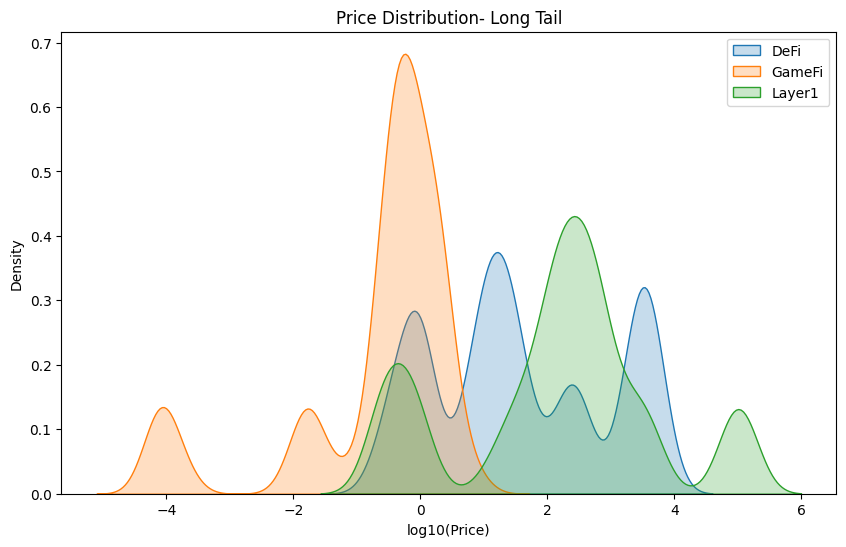

In [14]:
DeFi = all_historical_combined_filled[all_historical_combined_filled['category']=='DeFi']
GameFi = all_historical_combined_filled[all_historical_combined_filled['category']=='GameFi']
Layer1 = all_historical_combined_filled[all_historical_combined_filled['category']=='Layer 1']
plt.figure(figsize=(10,6))

# KDE plot
sns.kdeplot(np.log10(DeFi['price']), label='DeFi', fill=True)
sns.kdeplot(np.log10(GameFi['price']), label='GameFi', fill=True)
sns.kdeplot(np.log10(Layer1['price']), label='Layer1', fill=True)

plt.xlabel('log10(Price)')
plt.ylabel('Density')
plt.title('Price Distribution- Long Tail')
plt.legend()
plt.show()

Scatter plots were used to examine the relationships between variables. 

The charts indicate a positive correlation in price change rates across all sectors.

Besides, the correlation matrix shows the correlation coefficients are all above 0.8

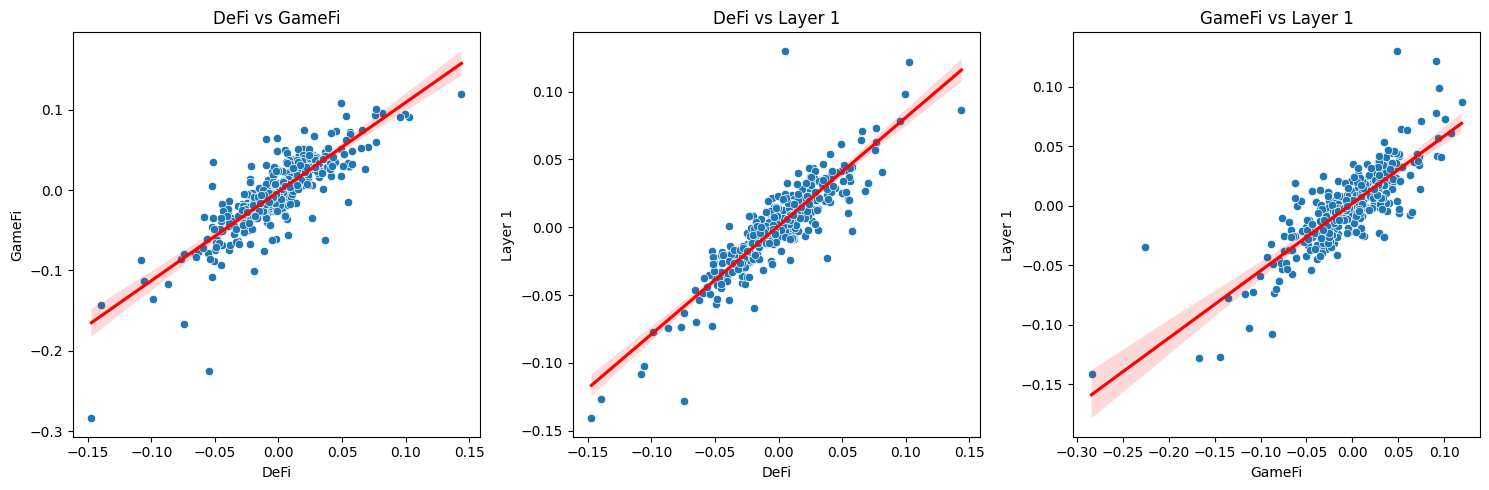

In [15]:
df = all_historical_combined_filled.copy()
df = df.sort_values(by=['coin_name','date'])

# Calculate log returns for each coin's price
df['price_log_return'] = df.groupby('coin_name')['price'].transform(lambda x: np.log(x) - np.log(x.shift(1)))
df["pct_change_7d"] = df.groupby('coin_name')["price"].pct_change(7) * 100
# Calculate average returns by category and date
avg_returns = df.groupby(['category','date'])['price_log_return'].mean().reset_index()

# Pivot table: each column represents a category, each row represents a date
pivot_df = avg_returns.pivot(index='date', columns='category', values='price_log_return')

# Fill missing values (optional, fill with 0 or forward fill)
pivot_df = pivot_df.fillna(0)

# Plot pairwise scatter plots for three categories
pairs = [('DeFi','GameFi'), ('DeFi','Layer 1'), ('GameFi','Layer 1')]
plt.figure(figsize=(15,5))
for i, (x_col, y_col) in enumerate(pairs, 1):
    plt.subplot(1,3,i)
    sns.scatterplot(x=pivot_df[x_col], y=pivot_df[y_col])
    sns.regplot(x=pivot_df[x_col], y=pivot_df[y_col], scatter=False, color='red')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'{x_col} vs {y_col}')

plt.tight_layout()
plt.show()

In [16]:
corr_matrix = pivot_df.corr()
print(corr_matrix)

category      DeFi    GameFi   Layer 1
category                              
DeFi      1.000000  0.837521  0.885847
GameFi    0.837521  1.000000  0.829896
Layer 1   0.885847  0.829896  1.000000


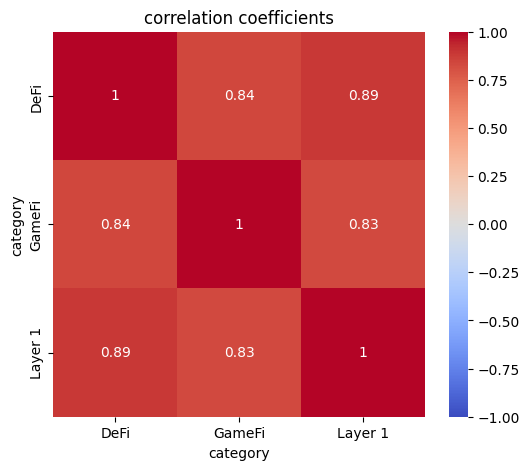

In [17]:
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("correlation coefficients")
plt.show()

# Step 4: Ask a question about your data

Based on the results of the previous Exploratory Data Analysis, this report found that the price and trading volume of coins within the same category vary significantly. As a cryptocurrency investor, **this report aims to investigate whether a high market capitalization concentration in the top 2–3 coins of a sector implies a higher investment risk**.

This report uses the Herfindahl-Hirschman Index (HHI) to evaluate the concentration degree of each sector.

In [18]:
hhi = grouped.groupby('category')['percent'].apply(lambda x: (x**2).sum())

print(hhi)

category
DeFi       2057.832131
GameFi     1327.893918
Layer 1    5919.882060
Name: percent, dtype: float64


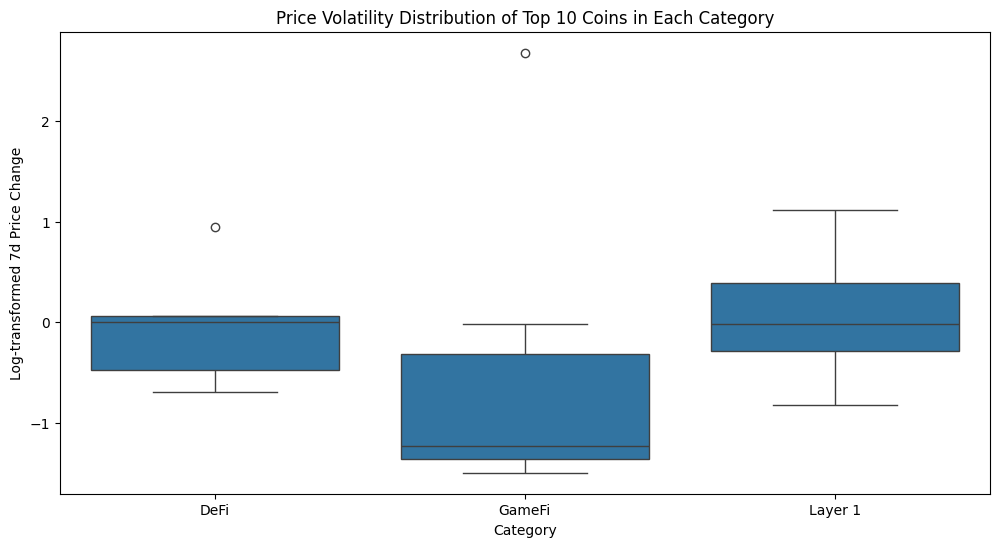

In [22]:
# Calculate mean pct_change_7d for each coin within each category
# Use groupby with as_index=False to avoid MultiIndex issues
category = (df.groupby(['category', 'coin_name'], as_index=False)['pct_change_7d']
            .mean())

# Handle log transformation: pct_change_7d can be negative, so we need to handle it carefully
# Since pct_change_7d is a percentage change, it can be negative
# We'll use log transformation on absolute values and preserve the sign
# Alternative: filter out negative values or use log1p
category['pct_change_7d_log'] = np.sign(category['pct_change_7d']) * np.log1p(np.abs(category['pct_change_7d']))

# Filter out infinite values that might occur from log transformation
category = category[np.isfinite(category['pct_change_7d_log'])]

plt.figure(figsize=(12,6))
sns.boxplot(
    data=category,
    x='category',
    y='pct_change_7d_log'
)
plt.title("Price Volatility Distribution of Top 10 Coins in Each Category")
plt.xlabel("Category")
plt.ylabel("Log-transformed 7d Price Change")
plt.show()


## Hypothesis Test

**Summary of Results：**

The Kruskal–Wallis test shows a significant difference in the mean 7-day log returns across the three categories (p = 0.022 < 0.05). The Levene’s test indicates that the variances are not significantly different (p = 0.592 > 0.05), suggesting that the level of volatility within each category is similar.

**Investment implication:**

Although different categories exhibit distinct average return patterns, the within-category variability remains comparable. This means that while the typical (average) performance differs across categories, their internal volatility profiles are largely alike.

In [24]:
group_data = [
    category[category['category'] == cat]['pct_change_7d_log'].dropna()
    for cat in ['DeFi','GameFi','Layer 1']
]

# Kruskal-Wallis test
h_stat, p_value = kruskal(*group_data)
print('Starting mean test')
print("Kruskal–Wallis H-stat:", h_stat)
print("p-value:", p_value)

# Variance test
stat, p_value = levene(*group_data)
print('\nStarting variance test')
print("Levene H-stat:", stat)
print("p-value:", p_value)

Starting mean test
Kruskal–Wallis H-stat: 7.6023399014778335
p-value: 0.022344614459518755

Starting variance test
Levene H-stat: 0.5359417175674622
p-value: 0.5916910991980165


C:\Users\86158\AppData\Local\Temp\ipykernel_24988\2788549039.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GameFi[['price_t','market_t','volume_t']] = pt.fit_transform(
C:\Users\86158\AppData\Local\Temp\ipykernel_24988\2788549039.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GameFi[['price_t','market_t','volume_t']] = pt.fit_transform(
C:\Users\86158\AppData\Local\Temp\ipykernel_24988\2788549039.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

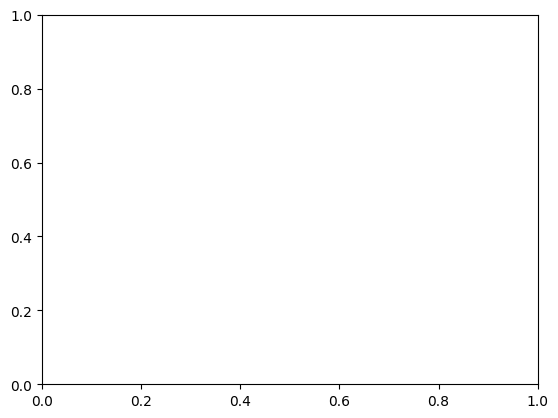

In [26]:
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import PowerTransformer

# Create a copy to avoid SettingWithCopyWarning
GameFi_copy = GameFi.copy()

# Apply PowerTransformer transformation
pt = PowerTransformer(method='yeo-johnson')
GameFi_copy[['price_t','market_t','volume_t']] = pt.fit_transform(
    GameFi_copy[['price','market_cap','volume_24h']]
)

# Prepare data for boxplot: groupby returns a GroupBy object, need to extract data as a list
# plt.boxplot() needs a list of arrays, not a GroupBy object
data_for_boxplot = []
labels = []

for category in all_historical_combined_filled['category'].unique():
    category_data = all_historical_combined_filled[
        all_historical_combined_filled['category'] == category
    ]['market_cap'].dropna()
    data_for_boxplot.append(category_data)
    labels.append(category)

plt.figure(figsize=(10, 6))
plt.boxplot(data_for_boxplot, labels=labels)
plt.title('Market Cap Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Market Cap')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()
